# **Exam Project Supervised Learning** - June 2023 - Canesi Gabriele, Casati Rebecca





# **SIFT/BoW**

## Preliminary
All the necessary imports and libraries are here:

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import glob
import os
import pickle 
import itertools
import io
import torchvision.transforms as transforms
import cv2 

from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

Utility functions:
Functions helpful to calculate the accuracy and to plot the confusion matrix

In [19]:
# TOTAL ACCURACY
def compute_accuracy(confusion_matrix):
    # sum of the elements on the diagonal (trace of the matrix) (= correct predictions)
    diagonal_sum = np.trace(confusion_matrix)
    # sum of all the elements (= total predictions)
    total_sum = np.sum(confusion_matrix)
    # accuracy = correct predictions / all the predictions
    accuracy = diagonal_sum / total_sum
    return accuracy

# PLOT CONFUSION MATRIX
# second argument is a list of the class labels, to plot on the y and x axis of the matrix
def plot_confusionmatrix(confusion_mat, class_labels):
    fig5, ax = plt.subplots()

    # Create the heatmap
    heatmap = ax.imshow(confusion_mat, cmap='Blues')

    # Set the x-axis and y-axis labels 
    ax.set_xticks(range(0,100, 4))
    ax.set_yticks(range(0,100, 4))

    # Rotate the x-axis labels
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

    # Add colorbar
    cbar = plt.colorbar(heatmap)

    # Set the title and axis labels
    ax.set_title('Confusion Matrix Heatmap')
    ax.set_xlabel('Predicted Classes')
    ax.set_ylabel('Actual Classes')
    
    # Show the plot
    plt.tight_layout()
    plt.savefig("Confusion_matrix.png")

### Import Dataset

Import and unzip the dataset:

In [2]:
!gdown "1wYs0vMlE7KuY5eABPCVRhgDpHEC8EviR"
!unzip -q -n "/content/TinyImageNet.zip" -d data 

Downloading...
From: https://drive.google.com/uc?id=1wYs0vMlE7KuY5eABPCVRhgDpHEC8EviR
To: /content/TinyImageNet.zip
100% 483M/483M [00:04<00:00, 102MB/s]


Import and unzip the saved important variables (descriptors for the training and the test set):

In [3]:
!gdown "11lJDsxLZcSqHu68TdYE4zWgBz3q6Nuce"
!unzip -q -n "/content/Bagofwordsparameters.zip" -d data 

Downloading...
From: https://drive.google.com/uc?id=11lJDsxLZcSqHu68TdYE4zWgBz3q6Nuce
To: /content/Bagofwordsparameters.zip
100% 845M/845M [00:11<00:00, 70.5MB/s]


Import and unzip the best classifer trained:

In [4]:
!gdown "128Qb-MLq4184J33A6c781atBXgrKpttl"
!unzip -q -n "/content/SVC_rbf.pkl.zip" -d data

Downloading...
From: https://drive.google.com/uc?id=128Qb-MLq4184J33A6c781atBXgrKpttl
To: /content/SVC_rbf.pkl.zip
100% 34.1M/34.1M [00:00<00:00, 61.4MB/s]


### Load Varibales saved

Loading of the descriptors saved and of the classifier:

NB: This three variables are useful to decide if download variables and best model, or train a new model from scratch. Putting load_variable and load_classifier "True" you download the model, doing the contrary you train new one from zero. Save_varaible "True" means save the descriptors extracted in prevoius steps.


In [5]:
save_varaible = False
load_variable = True
load_classifier = True

In [6]:
if load_variable == True:

  # open the file in binary mode
  with open('/content/data/Bagofwordsparameters/descrip_train.pkl', 'rb') as f:
    # load the content of the file, saved in f, in the variable descrip_train
    descrip_train = pickle.load(f)

  with open('/content/data/Bagofwordsparameters/flatten_descrip_train.pkl', 'rb') as f:
    flatten_descrip = pickle.load(f)

  with open('/content/data/Bagofwordsparameters/label_train.pkl', 'rb') as f:
    label_train = pickle.load(f)

  with open('/content/data/Bagofwordsparameters/descrip_test.pkl', 'rb') as f:
    descrip_test = pickle.load(f)

  with open('/content/data/Bagofwordsparameters/label_test.pkl', 'rb') as f:
    label_test = pickle.load(f)

  with open('/content/data/SVC_rbf.pkl', 'rb') as f:
    classifier = pickle.load(f)

### Inspection of the data

Check in what color system are coded the images (they are all RGB):

In [5]:
check_rgb = False

In [6]:
if check_rgb:
    # TRAIN SET
    lst = glob.glob("/content/data/TinyImageNet/train/*/*.jpg")

    # number of gray images in the train (train/val)
    num_gray_train = 0
    # number of RGB images in the train (train/val)
    rgb_train = 0
    # number of RGBA images in the train (train/val)
    rgba_train = 0
    # number of BGR (or other) images in the train (train/val)
    bgr_train = 0

    for pt in lst:
        im=Image.open(pt)
        bands = im.getbands()
        #print(bands)
        # increase the total number of gray images by one
        if len(bands) < 3:
            num_gray_train += 1
        # increase the total number of RGB images by one
        if im.mode == 'RGB':
            rgb_train += 1
        # increase the total number of RGBA images by one
        elif im.mode == 'RGBA':
            rgba_train += 1
        # increase the total number of BGR images by one
        else:
            bgr_train += 1


    # VAL SET
    lst = glob.glob("/content/data/TinyImageNet/val/*/*.jpg")

    # number of gray images in the val (test)
    num_gray_val = 0
    # number of RGB images in the val (test)
    rgb_val = 0
    # number of RGBA images in the val (test)
    rgba_val = 0
    # number of BGR images in the val (test)
    bgr_val = 0

    for pt in lst:
        im=Image.open(pt)
        bands = im.getbands()
        if len(bands) < 3 :
            num_gray_train += 1
        if im.mode == 'RGB':
            rgb_val += 1
        elif im.mode == 'RGBA':
            rgba_val += 1
        else:
            bgr_val += 1

    # print the results
    # total number of gray images
    print("Number of gray images in train:", num_gray_train)
    print("Number of gray images in val:", num_gray_val)
    # total number of RGB images
    print("Number of RGB images in train:", rgb_train)
    print("Number of RGB images in val:", rgb_val)
    # total number of RGBA images
    print("Number of RGBA images in train:", rgba_train)
    print("Number of RGBA images in val:", rgba_val)
    # total number of BGR images
    print("Number of BGR or other images in train:", bgr_train)
    print("Number of BGR or other images in val:", bgr_val)

### DataLoader and upload images

Read and convert data into Pandas Dataframe (we load only the train and validation file since the train data will be divided into train and validation, while the validation data will be used as test):



In [7]:
# read and convert into pandas dataframe
# train (saved as train and val)
df_train_val = pd.read_csv("/content/data/TinyImageNet/train.txt", sep = " ", header = None)
# val (saved as test)
df_test = pd.read_csv("/content/data/TinyImageNet/val.txt", sep = " ", header = None)

# rename the columns
df_train_val.columns = ["image", "label"]
df_test.columns = ["image", "label"]

Split the train set between training (70%) and validation (30%) with stratified sampling:

In [9]:
# initialize two empty pandas dataframe
df_train = pd.DataFrame()
df_val = pd.DataFrame()
# Proportional Split
# iteration over all the images of train set, with a step of 1000
# to get batches of 1000 elements (single class of the train set)
for i in range(0,100000,1000):
  # dataframe of the single class i (1000 images)
  df_class = df_train_val.loc[i:(i+999)]
  # random shuffle of the rows of the dataframe of the class i
  df_class = df_class.sample(frac=1).reset_index(drop=True)
  # split each class in two dataframes, one for train and one for validation
  train_df, val_df = train_test_split(df_class, test_size=0.3, random_state=42)
  # add the train and validation dataframe at the dataframes of the other classes
  df_train = pd.concat([df_train,train_df])
  df_val = pd.concat([df_val, val_df])

# Shuffle the new dataset
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_val = df_val.sample(frac=1).reset_index(drop=True)

# transformation to numpy
df_train = df_train.to_numpy()
df_val = df_val.to_numpy()

Shuffle also the test set:

In [10]:
df_test = df_test.sample(frac=1).reset_index(drop=True)

# transform to numpy
df_test = df_test.to_numpy()

Dataloader (documentation: [my dataloader](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class)):

In [11]:
class TinyImageNetDataset(Dataset):
    """TinyImageNet dataset."""

    def __init__(self, pd_dataframe, root_dir, transform = None):
        """
        Arguments:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = pd_dataframe
        # path
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name, label = self.data[idx]
        # open the image
        image = Image.open(os.path.join(self.root_dir, img_name))
    
        # the function returns a dictionary
        sample = {'image': image, 'label': torch.tensor(label)}
        

        if self.transform:
            image = self.transform(image)
            sample = {'image': image, 'label': torch.tensor(label)}

        return sample

Create the train, validation and test set:

In [12]:
trainset = TinyImageNetDataset(df_train, "/content/data/TinyImageNet")
valset = TinyImageNetDataset(df_val, "/content/data/TinyImageNet")
testset = TinyImageNetDataset(df_test, "/content/data/TinyImageNet")

print("Length train set: %d \n \t val set: %d \n \t test set: %d" %(len(trainset), len(valset), len(testset)))

Length train set: 70000 
 	 val set: 30000 
 	 test set: 10000


## Training

### Features extraction (SIFT)

Detection of the keypoints and the descriptors for each image. Descriptors then are saved in two list: in the fisrt list the descriptors are divided by image, in the second list there are all the descriptors without any division.

In [13]:
if load_variable == False:
  
  # first format: descriptors divided by image
  descrip_train = []
  # second format: all descriptors without division
  flatten_descrip = []
  # true labels of the train images
  label_train = []
  # list of indices of the images of which the descriptors are not computed
  ind_nontype = []

  # SIFT
  sift = cv2.xfeatures2d.SIFT_create(nfeatures=2000)

  for i in range(len(trainset)):
    image = trainset[i]["image"]
    label_train.append(trainset[i]['label'].item())

    # extract descriptors
    _, descriptors = sift.detectAndCompute(np.array(image), None)
    # if the descriptors were succesfully computed
    if type(descriptors) == np.ndarray:
      # append the array descriptors to the list (list of array)
      descrip_train.append(descriptors) 
      # extend the flatten list
      flatten_descrip.extend(descriptors)
    # if the descriptors were not computed
    elif type(descriptors) != np.ndarray:
      ind_nontype.append(i)

  # For some images no features are detected. Remove these images
  label_train = [item for i, item in enumerate(label_train) if i not in ind_nontype]
      

Print one image and the keypoints detectd by SIFT:

In [14]:
if load_variable == False:
  sift_image = cv2.drawKeypoints(np.array(image), _, np.array(image))
  # show the image
  cv2_imshow(sift_image)
  # save the image
  cv2.destroyAllWindows()

### Clustering of the features

Mini-Batch K-Means clustering:

In [15]:
n_cluster = 2000

kmeans = MiniBatchKMeans(n_clusters = n_cluster, random_state = 0, batch_size = 2048, n_init = "auto").fit(np.array(flatten_descrip))

Histogram of visual words per image:

In [16]:
# list of histograms, one for each image
histogram = [[] for _ in range(len(descrip_train))]

# for each images for which descriptors were actually computed
for i in range(len(descrip_train)):
  # cluster the descriptors of the image i
  k_predict = kmeans.predict(descrip_train[i])
  # create the histogram counting the occurecies of each visual word
  histogram1 = np.bincount(k_predict, minlength = n_cluster)
  # normalize the histogram
  histogram1 = histogram1/len(descrip_train[i])
  histogram[i] = histogram1

Plot one Histogram

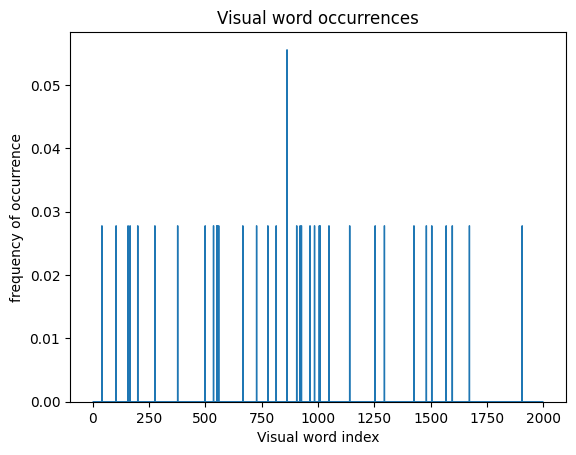

In [17]:
plt.stairs(histogram[9])
plt.xlabel("Visual word index")
plt.ylabel("frequency of occurrence")
plt.title("Visual word occurrences")
plt.show()

### Classifier

Train the classifier with the histograms created before and the labels

In [18]:
if load_classifier == False:
  classifier = SVC(kernel = 'rbf').fit(histogram,label_train)

### Checking Overfitting

In these cells predictions over the train set, are computed too understand if there is overfitting or not.

NB: Cells below take some hours to be completly execute, results are written in the report

In [38]:
prediction_svc_train = classifier.predict(histogram)

In [39]:
confusion_mat_train = confusion_matrix(label_train, prediction_svc_train)

Accuracy on the train test

In [40]:
accuracy = compute_accuracy(confusion_mat_train)
print("The total accuracy is %.3f%%" %(accuracy*100))

The total accuracy is 70.210%


## Testing

All the operations (extraction of features and creation of histograms) are now repeated for the test set:

(In this case the flatten list of descriptors is not needed, it was needed before for the training images in order to perform the clustering of the descriptors; now the clusters are already formed)

In [20]:
if load_variable == False:

  descrip_test = []
  label_test = []
  ind_nontype = []

  sift = cv2.xfeatures2d.SIFT_create()

  for i in range(len(testset)):
    image = testset[i]["image"]
    label_test.append(testset[i]['label'].item())
    
    _, descriptors = sift.detectAndCompute(np.array(image), None)
    if type(descriptors) == np.ndarray:
      descrip_test.append(descriptors) 
    elif type(descriptors) != np.ndarray:
      ind_nontype.append(i)

  # From some picture no features are detected. Remove of that images
  label_test = [item for i, item in enumerate(label_test) if i not in ind_nontype]

In [21]:
histogram_lab = [[] for _ in range(len(descrip_test))]
for i in range(len(descrip_test)):
  k_predict = kmeans.predict(descrip_test[i])
  histogram2 = np.bincount(k_predict, minlength=n_cluster)
  histogram2 = histogram2/len(descrip_test[i])
  histogram_lab[i] = histogram2

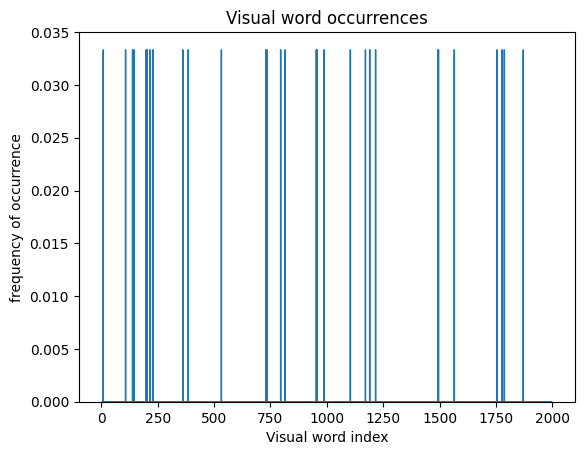

In [22]:
plt.stairs(histogram_lab[9])
plt.xlabel("Visual word index")
plt.ylabel("frequency of occurrence")
plt.title("Visual word occurrences")
plt.show()

Predict the classes of test images with the classifier trained before

NB: This cell take half an hour to be execute. Results are written in the report

In [23]:
prediction_svc = classifier.predict(histogram_lab)

### Evaluation
Compute some metrics and graphs, to better interpret the results.

Compute the Confusion Matrix:

In [24]:
confusion_mat = confusion_matrix(label_test, prediction_svc)

Plot the Confusion Matrix:

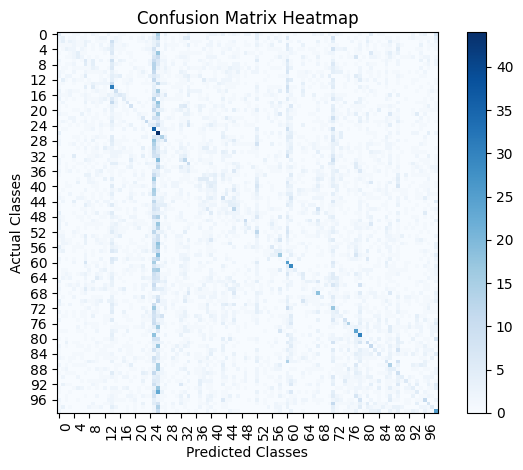

In [25]:
# range(100) contains the labels of the classes (which are the numbers from 0 to 99)
plot_confusionmatrix(confusion_mat, range(100))

Total Accuracy:

In [26]:
accuracy = compute_accuracy(confusion_mat)
print("The total accuracy is %.3f%%" %(accuracy*100))

The total accuracy is 6.897%


Accuracy for each class:

In [27]:
# list of 100 elements in which the element i contain the number of correct predictions...
# that the model made of that class
class_correct = []
# list of 100 elements in which the element i contain the total number of predictions...
# that the model made of that class
class_total = []
# labels of the classes
classes = np.arange(100)
# list of accuracies for each class
accuracy_classes = []

for i in range(100):
  vertical_array = confusion_mat[:, i]
  # the sum of the vertical_array is the total number of times that the class was predicted
  class_total.append(np.sum(vertical_array))
  # the i-th element of the vertical_array is the element (i,i) on the diagonal...
  # of the confusion matrix, which is the number of correct predictions of the class i
  class_correct.append(vertical_array[i])

for i in range(100):
    accuracy_classes.append(100 * class_correct[i] / class_total[i])
    print('Accuracy of %5s : %2d %%' % (
        classes[i], accuracy_classes[i]))

Accuracy of     0 :  4 %
Accuracy of     1 :  5 %
Accuracy of     2 :  2 %
Accuracy of     3 :  2 %
Accuracy of     4 :  3 %
Accuracy of     5 :  8 %
Accuracy of     6 :  4 %
Accuracy of     7 :  4 %
Accuracy of     8 :  1 %
Accuracy of     9 :  3 %
Accuracy of    10 :  1 %
Accuracy of    11 :  1 %
Accuracy of    12 :  2 %
Accuracy of    13 :  3 %
Accuracy of    14 :  9 %
Accuracy of    15 :  9 %
Accuracy of    16 : 10 %
Accuracy of    17 :  7 %
Accuracy of    18 : 10 %
Accuracy of    19 : 11 %
Accuracy of    20 :  3 %
Accuracy of    21 :  6 %
Accuracy of    22 :  6 %
Accuracy of    23 : 17 %
Accuracy of    24 :  6 %
Accuracy of    25 :  4 %
Accuracy of    26 :  5 %
Accuracy of    27 : 11 %
Accuracy of    28 :  7 %
Accuracy of    29 :  4 %
Accuracy of    30 :  1 %
Accuracy of    31 :  4 %
Accuracy of    32 :  2 %
Accuracy of    33 :  9 %
Accuracy of    34 :  6 %
Accuracy of    35 :  5 %
Accuracy of    36 :  3 %
Accuracy of    37 :  0 %
Accuracy of    38 :  6 %
Accuracy of    39 :  3 %


Bar chart of class accuracies:

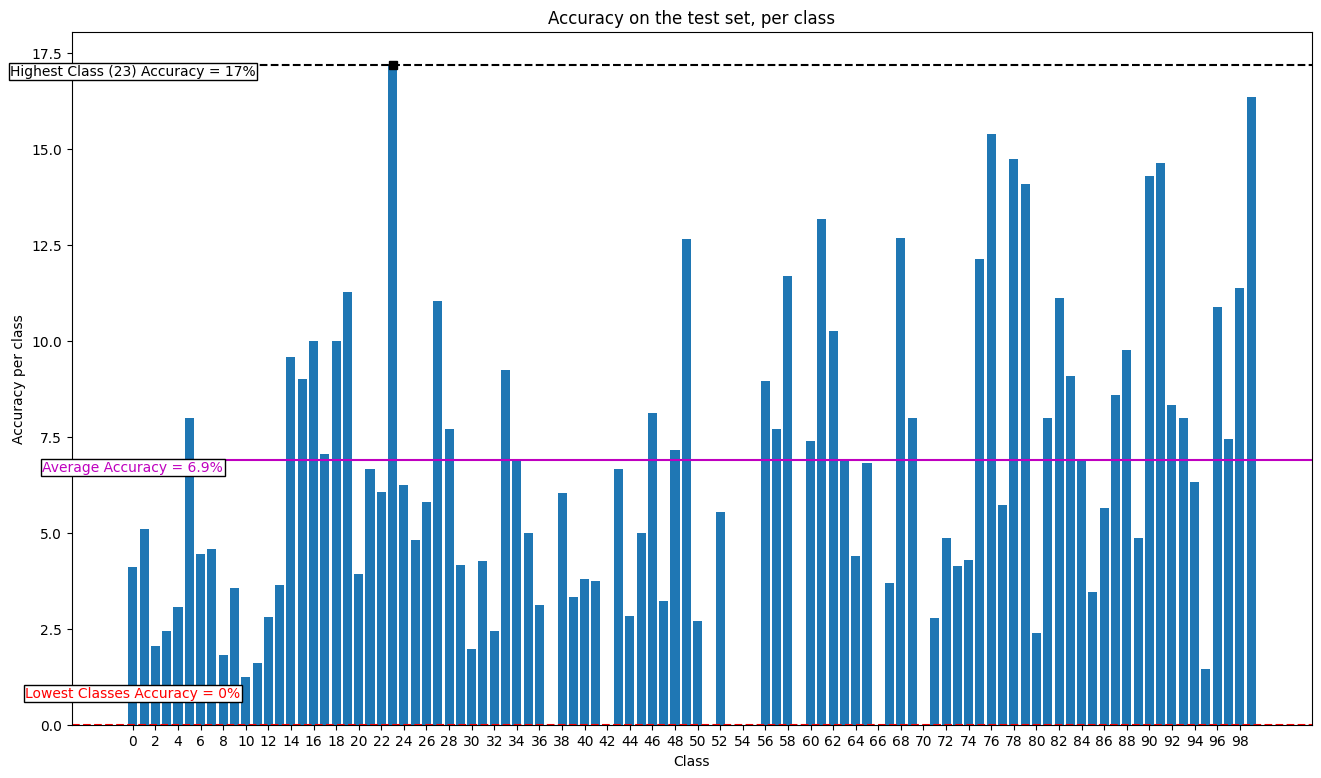

In [28]:
fig1 = plt.figure(figsize = (16,9))

# bar chart
plt.bar(classes, accuracy_classes, align = "center")

# axis options
plt.xlabel("Class")
plt.ylabel("Accuracy per class")
plt.xticks(range(0,100, 2))
#plt.grid()
plt.title("Accuracy on the test set, per class")

# assign the values
average_accuracy = 6.9
lowest_class = 70
highest_class = 23

# lines
plt.axhline(y = average_accuracy, color='m', linestyle='solid')
plt.axhline(y = accuracy_classes[lowest_class], color='r', linestyle='--')
plt.axhline(y = accuracy_classes[highest_class], color='k', linestyle='--')

# dots
plt.plot(highest_class, accuracy_classes[highest_class], 's', color='k')

# texts
plt.text(0, 6.89, 'Average Accuracy = 6.9%', fontsize=10, color='m',
         verticalalignment ='top', 
         horizontalalignment ='center',
         bbox ={'facecolor':'white', 
                'pad':1})
plt.text(0, accuracy_classes[70]+1, 'Lowest Classes Accuracy = 0%', fontsize=10, color='r',
         verticalalignment ='top', 
         horizontalalignment ='center',
         bbox ={'facecolor':'white', 
                'pad':1})
plt.text(0, accuracy_classes[23], 'Highest Class (23) Accuracy = 17%', fontsize=10, color='k',
         verticalalignment ='top', 
         horizontalalignment ='center',
         bbox ={'facecolor':'white', 
                'pad':1})


plt.savefig("Accuracies.png")
plt.show()

In [18]:
# Save variable to a file
with open('SVC_rbf_2.pkl', 'wb') as f:
    pickle.dump(classifier, f)

### Save the important variables 

In [ ]:
if save_varaible == True:

  with open('descrip_train.pkl', 'wb') as f:
      pickle.dump(descrip_train, f)

  with open('flatten_descrip_train.pkl', 'wb') as f:
      pickle.dump(flatten_descrip, f)

  with open('label_train.pkl', 'wb') as f:
      pickle.dump(label_train, f)

  with open('descrip_test.pkl', 'wb') as f:
      pickle.dump(descrip_test, f)

  with open('label_test.pkl', 'wb') as f:
      pickle.dump(label_test, f)


## Diffusion
Last evaluation step: 11 images, generated with diffusion models and representing  two animals together that belong to two different classes (dog and cat), are classified from the SVC previously trained.

### Load Dataset

Download and Unzip the dataset (11 images)

In [29]:
!gdown "1OfD1CRHsSIei_VaYGfRG5A7Sbh6kNOU8"
!unzip -q -n "/content/Testing_diffusion.zip" -d data 

Downloading...
From: https://drive.google.com/uc?id=1OfD1CRHsSIei_VaYGfRG5A7Sbh6kNOU8
To: /content/Testing_diffusion.zip
100% 853k/853k [00:00<00:00, 99.7MB/s]


### import datat and extract Descriptors

Importing Data

In [30]:
# read the dataset with the 11 generated images as a pandas dataframe
df_testing_diff = pd.read_csv("/content/data/Testing_diffusion/testing_diffusion.txt", sep = " ", header = None,encoding="utf-16")
# drop the third column (NaN)
df_testing_diff = df_testing_diff.drop([2], axis=1)
# rename the columns
df_testing_diff.columns = ["image", "label"]

# convert in numpy array
df_testing_diff = df_testing_diff.to_numpy()
df_testing_diff[:, 1] = df_testing_diff[:, 1].astype(float)

In [31]:
transform_diff = transforms.Compose([            
    transforms.Resize((64,64))])

In [32]:
diff_set = TinyImageNetDataset(df_testing_diff,"/content/data",transform_diff)

SIFT for extracting descriptors

In [33]:
descrip_diff = []
ind_nontype = []

sift = cv2.xfeatures2d.SIFT_create()

for i in range(11):
    image = diff_set[i]["image"]
    
    _, descriptors = sift.detectAndCompute(np.array(image), None)
    if type(descriptors) == np.ndarray:
      descrip_diff.append(descriptors) 
    elif type(descriptors) != np.ndarray:
      ind_nontype.append(i)

### Create Histograms

In [34]:
histogram_diff = [[] for _ in range(len(descrip_diff))]
for i in range(len(descrip_diff)):
  k_predict = kmeans.predict(descrip_diff[i])
  histogram2 = np.bincount(k_predict, minlength=n_cluster)
  histogram2 = histogram2/len(descrip_diff[i])
  histogram_diff[i] = histogram2

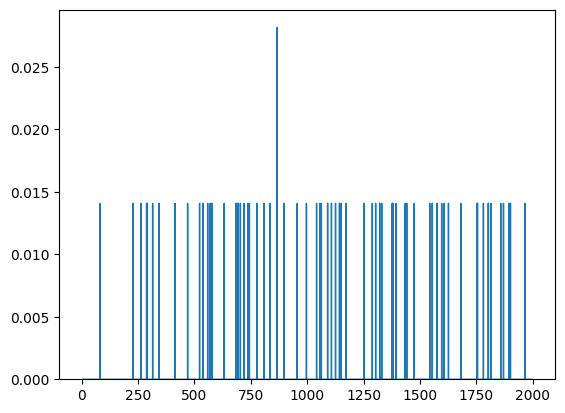

In [35]:
plt.stairs(histogram_diff[5])
plt.show()

### Classifer and prediction

In [36]:
prediction_svc = classifier.predict(histogram_diff)

Predicted Classes

In [37]:
print(prediction_svc)

[79 37 25 25 52 25 25 25 89 72 75]
